<a href="https://colab.research.google.com/github/murasakiw/ML2/blob/main/A4_DL_TC5033_text_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TC 5033
### Text Generation

<br>

#### Activity 4: Building a Simple LSTM Text Generator using WikiText-2
<br>

### Team 15
- Héctor Raúl Vázquez González - A00565542
- Ronald David Zuniga Sánchez - A01686240
- Sergio Omar Esparza Hernández - A01794338
- Hugo Enrique Solano Ortega - A01794456



Objective:
  - Gain a fundamental understanding of Long Short-Term Memory (LSTM) networks.
  - Develop hands-on experience with sequence data processing and text generation in PyTorch. Given the simplicity of the model, amount of data, and computer resources, the text you generate will not replace ChatGPT, and results must likely will not make a lot of sense. Its only purpose is academic and to understand the text generation using RNNs.
  - Enhance code comprehension and documentation skills by commenting on provided starter code.
    
<br>

Instructions:
  - Code Understanding: Begin by thoroughly reading and understanding the code. Comment each section/block of the provided code to demonstrate your understanding. For this, you are encouraged to add cells with experiments to improve your understanding

  - Model Overview: The starter code includes an LSTM model setup for sequence data processing. Familiarize yourself with the model architecture and its components. Once you are familiar with the provided model, feel free to change the model to experiment.

  - Training Function: Implement a function to train the LSTM model on the WikiText-2 dataset. This function should feed the training data into the model and perform backpropagation.

  - Text Generation Function: Create a function that accepts starting text (seed text) and a specified total number of words to generate. The function should use the trained model to generate a continuation of the input text.

  - Code Commenting: Ensure that all the provided starter code is well-commented. Explain the purpose and functionality of each section, indicating your understanding.

  - Submission: Submit your Jupyter Notebook with all sections completed and commented. Include a markdown cell with the full names of all contributing team members at the beginning of the notebook.
    
<br>

- Evaluation Criteria:
    - Code Commenting (60%): The clarity, accuracy, and thoroughness of comments explaining the provided code. You are suggested to use markdown cells for your explanations.

    - Training Function Implementation (20%): The correct implementation of the training function, which should effectively train the model.

    - Text Generation Functionality (10%): A working function is provided in comments. You are free to use it as long as you make sure to uderstand it, you may as well improve it as you see fit. The minimum expected is to provide comments for the given function.

    - Conclusions (10%): Provide some final remarks specifying the differences you notice between this model and the one used  for classification tasks. Also comment on changes you made to the model, hyperparameters, and any other information you consider relevant. Also, please provide 3 examples of generated texts.



# Code Setup and Data Preparation

In [ ]:
#General Data Wrangling Libraries
import numpy as np
import matplotlib.pyplot as plt
#PyTorch libraries
import torch
import torchtext
from torchtext.datasets import WikiText2
# Dataloader library
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm

import random

In [ ]:
#pip install portalocker>=2.0.0

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


WikiText-2 Dataset consists of a collection of Wikipedia articles with over 100 million tokens that include words, subwords, and characters.

In [ ]:
train_dataset, val_dataset, test_dataset = WikiText2()

Basic english tokenizer is used to build a vocabulary setting rules for special tokens.

In [ ]:
tokeniser = get_tokenizer('basic_english')
def yield_tokens(data):
    for text in data:
        yield tokeniser(text)

Special tokens are defined as follows:
*  unk (unknown)
*  pad (padding)
*  bos (beginning of sequence)
*  eos (end of sequence).

In [ ]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

A function is defined  to process raw text data into input-output pairs set for training.

The function tokenizes the text then converts the tokens to indices using the vocabulary, and creates sequences of a specified length.

The resulting data is then split into input (x) and target (y) tensors.

In [ ]:
seq_length = 50
def data_process(raw_text_iter, seq_length = 50):
    data = [torch.tensor(vocab(tokeniser(item)), dtype=torch.long) for item in raw_text_iter]
    data = torch.cat(tuple(filter(lambda t: t.numel() > 0, data))) #remove empty tensors
#     target_data = torch.cat(d)
    return (data[:-(data.size(0)%seq_length)].view(-1, seq_length),
            data[1:-(data.size(0)%seq_length-1)].view(-1, seq_length))

# # Create tensors for the training set
x_train, y_train = data_process(train_dataset, seq_length)
x_val, y_val = data_process(val_dataset, seq_length)
x_test, y_test = data_process(test_dataset, seq_length)

Tensors are created to prepare the dataset for training by converting the split Train, Val, and Test tokens.

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

Pytorch Dataloader is used to create the corresponding training, validation, and test dataset batches.

In [ ]:
batch_size = 64  # choose a batch size that fits your computation resources
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Model Preparation

The LSTM model is defined with a standard architecture consisting of an embedding layer, an LSTM layer, and a linear layer using a forward method to process the input sequences through the layers.

In [ ]:
# Define the LSTM model
# Feel free to experiment
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, text, hidden):
        embeddings = self.embeddings(text)
        output, hidden = self.lstm(embeddings, hidden)
        decoded = self.fc(output)
        return decoded, hidden

    def init_hidden(self, batch_size):

        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))



vocab_size = len(vocab) # vocabulary size
emb_size = 100 # embedding size
neurons = 128 # the dimension of the feedforward network model, i.e. # of neurons
num_layers = 5 # the number of nn.LSTM layers
model = LSTMModel(vocab_size, emb_size, neurons, num_layers)


In [ ]:
    '''
    The following are possible instructions you may want to conside for this function.
    This is only a guide and you may change add or remove whatever you consider appropriate
    as long as you train your model correctly.
        - loop through specified epochs
        - loop through dataloader
        - don't forget to zero grad!
        - place data (both input and target) in device
        - init hidden states e.g. hidden = model.init_hidden(batch_size)
        - run the model
        - compute the cost or loss
        - backpropagation
        - Update paratemers
        - Include print all the information you consider helpful

    '''

"\nThe following are possible instructions you may want to conside for this function.\nThis is only a guide and you may change add or remove whatever you consider appropriate\nas long as you train your model correctly.\n    - loop through specified epochs\n    - loop through dataloader\n    - don't forget to zero grad!\n    - place data (both input and target) in device\n    - init hidden states e.g. hidden = model.init_hidden(batch_size)\n    - run the model\n    - compute the cost or loss\n    - backpropagation\n    - Update paratemers\n    - Include print all the information you consider helpful\n\n"

Definition of a plot function to visuialize training loss over each epoch.

In [ ]:
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in data_loader:
            xi = data.to(device=device, dtype=torch.long)
            yi = targets.to(device=device, dtype=torch.long)

            hidden = model.init_hidden(batch_size=data.size(0))
            scores, hidden = model(xi, hidden)
            predicted_labels = torch.argmax(scores, dim=2)
            correct += (predicted_labels == yi).sum().item()
            total += yi.numel()

    accuracy = correct / total
    return accuracy

In [ ]:
def plot_loss(train_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracy(val_accuracies):
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
train_losses=list() #Define list to store the training losses
val_accuracies = list() #Define list to store the validation accuracies

def train(model, epochs, optimiser):

    model = model.to(device=device) #Set the device to use GPU
    total_cost = 0
    val_cost = 0

    for epoch in range(epochs):
        total_cost = 0
        model.train()
        for data, targets in train_loader:
            # TO COMPLETE
            xi = data.to(device=device, dtype = torch.long) #Input data as torch tensors using GPU
            yi = targets.to(device=device, dtype = torch.long) #Labels / tokens as torch tensors using GPU

            hidden = model.init_hidden(batch_size=data.size(0))
            optimiser.zero_grad()
            scores, hidden = model(xi, hidden) #Obtain the ouput of the model
            scores_reshaped = scores.permute(0,2,1) #Obtain the ouput of the model
            cost = F.cross_entropy(scores_reshaped, yi) #Apply the cross_entropy function to calculate the cost

            cost.backward() #Calculate gradients with respect to all parameters of the model
            optimiser.step() #Update parameters considering the defined optimiser
            total_cost+=cost.item()

        #Obtain the training and validation accuracies
        average_cost = total_cost/len(train_loader)

        #Record list of training losses
        train_losses.append(average_cost)

        # Calculate model accuracy
        val_accuracy = calculate_accuracy(model, val_loader)
        val_accuracies.append(val_accuracy)

        print(f'Epoch: {epoch} --- Average cost: {average_cost: .4f} --- Validation Accuracy: {val_accuracy * 100:.2f}%')


# Model Training

In [ ]:
# Call the train function
loss_function = nn.CrossEntropyLoss()
lr = 0.005
epochs = 30
optimiser = optim.Adam(model.parameters(), lr=lr)
train(model, epochs, optimiser)

Epoch: 0 --- Average cost:  4.4512 --- Validation Accuracy: 22.36%
Epoch: 1 --- Average cost:  4.3478 --- Validation Accuracy: 22.41%
Epoch: 2 --- Average cost:  4.3015 --- Validation Accuracy: 22.37%
Epoch: 3 --- Average cost:  4.2660 --- Validation Accuracy: 22.38%
Epoch: 4 --- Average cost:  4.2319 --- Validation Accuracy: 22.21%
Epoch: 5 --- Average cost:  4.2027 --- Validation Accuracy: 22.20%
Epoch: 6 --- Average cost:  4.1759 --- Validation Accuracy: 22.17%
Epoch: 7 --- Average cost:  4.1522 --- Validation Accuracy: 22.28%
Epoch: 8 --- Average cost:  4.1283 --- Validation Accuracy: 22.18%
Epoch: 9 --- Average cost:  4.1080 --- Validation Accuracy: 22.14%
Epoch: 10 --- Average cost:  4.0882 --- Validation Accuracy: 22.04%
Epoch: 11 --- Average cost:  4.0716 --- Validation Accuracy: 22.14%
Epoch: 12 --- Average cost:  4.0542 --- Validation Accuracy: 22.13%
Epoch: 13 --- Average cost:  4.0374 --- Validation Accuracy: 21.94%
Epoch: 14 --- Average cost:  4.0271 --- Validation Accurac

# Model Evaluation

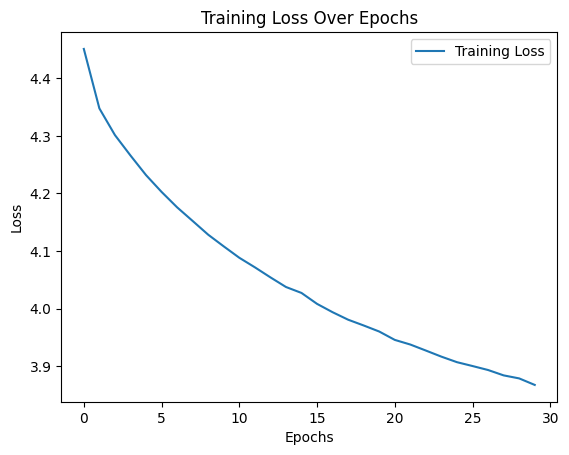

In [ ]:
# Plot Losses
plot_loss(train_losses)

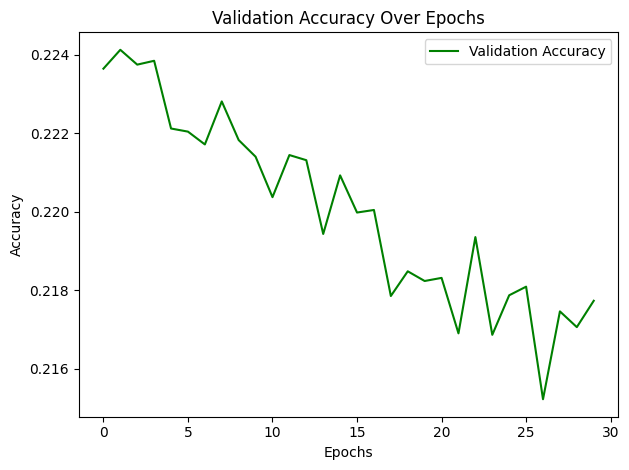

In [ ]:
# Plot accuracies
plot_accuracy(val_accuracies)

In [ ]:
def generate_text(model, start_text, num_words, temperature=1.0):

    model.eval()
    words = tokeniser(start_text)
    hidden = model.init_hidden(1)
    for i in range(0, num_words):
        x = torch.tensor([[vocab[word] for word in words[i:]]], dtype=torch.long, device=device)
        y_pred, hidden = model(x, hidden)
        last_word_logits = y_pred[0][-1]
        p = (F.softmax(last_word_logits / temperature, dim=0).detach()).to(device='cpu').numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(vocab.lookup_token(word_index))

    return ' '.join(words)

# Generate some text
print(generate_text(model, start_text="I found a", num_words=10))


i found a robot ! , with trulli , fiestas and roofs .


In [ ]:
# Generate some text
print(generate_text(model, start_text="I am in love with", num_words=10))

i am in love with perhaps me . the song features a bassline ' name


In [ ]:
# Generate some text
print(generate_text(model, start_text="Super Mario Land", num_words=10))

super mario land have also altered as the voice of raphael storytelling —


# Conclusions